# Machine learning for gelnetic data — Part 3: Elastic Net

## Reload librairies and data

Let us first reload the librairies and data used in previous parts. You can run this entire section (until the "Elastic Net" section) "blindly".

In [1]:
# make sure graphics are displayed inline (rather than opened in new windows)
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

In [3]:
plt.rc('font', **{'size': 14}) # font size for text on plots

In [4]:
from sklearn import decomposition, linear_model, metrics, model_selection, preprocessing

In [5]:
import scipy.stats as st

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

### Load data

In [7]:
# Load the genotype data
genotype_df = pd.read_csv("data/athaliana_small.genotype.txt")
genotype_df = genotype_df.set_index("Sample")

In [8]:
# Load the 2W phenotype
phenotype_df = pd.read_csv('data/athaliana_small.2W.pheno', delim_whitespace=True)

In [9]:
# Create the corresponding response vector
y_2W = np.array(phenotype_df["2W"])

In [10]:
# Create the corresponding data matrix
X_2W = np.array(genotype_df.loc[phenotype_df["IID"]])

In [11]:
num_snps = X_2W.shape[1]

In [12]:
# Load the list of candidate genes
with open('data/candidate_genes.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

In [13]:
# Load the SNP to gene mapping
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

### Correct the phenotype for population structure

In [14]:
pca = decomposition.PCA(n_components=5)
pca.fit(X_2W)
principal_components = X_2W.dot(pca.components_.T) 

# Fit a linear model between the phenotype and the principal components
model = linear_model.LinearRegression()
model.fit(principal_components, y_2W)

# Compute the model's residuals
y_pred = model.predict(principal_components)
y_2W_corrected = y_2W - y_pred

### Split the data in train/test

In [15]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W_corrected, test_size=0.2, random_state=42)
print(f"Training set shape: {X_2W_tr.shape}\nTest set shape: {X_2W_te.shape}")

Training set shape: (121, 9419)
Test set shape: (31, 9419)


### Scale the phenotype

In [16]:
scaler = preprocessing.StandardScaler()
scaler.fit(y_2W_tr.reshape(-1, 1))
y_2W_tr_scaled = scaler.transform(y_2W_tr.reshape(-1, 1)).reshape(-1, )

In [17]:
y_2W_te_scaled = scaler.transform(y_2W_te.reshape(-1, 1)).reshape(-1, )

### Functions to measure stability

In [18]:
def pearson_corr(vector1, vector2):
    """
    Returns Pearson's correlation between two vectors of 0 and 1. 
    """
    # if the first or the second vector is constant
    if (vector1 == vector1[0]).all() and (vector2 == vector2[0]).all():
            # return 1 if both are the same and 0 otherwise
            return 1. if (vector1[0] == vector2[0]) else 0.
    return st.pearsonr(vector1, vector2)[0]

Now we can define a function that measures the stability of a selection procedure.

In [19]:
def stability(X_train, y_train, selection_procedure, num_subsamples, subsample_size):
    """
    Sample the training data (X_train, y_train) num_subsamples times.
    Apply the selection procedure on each subsample.
    Return a mesure of stability of the procedure
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    selection_procedure: function
       input parameters: (training_data, training_labels)
       outputs: (n_features, ) np.array of 0 and 1 
           1 for selected features
           0 for non-selected features
    num_subsamples: int
        number of subsamples to use
    subsample_size: int
        number of samples in the subsample   
        
    Output
    ------
    pearson_corr: float
        Pearson's measure of stability of the selection procedure
    """
    n_samples, n_features = X_train.shape
    sample_indices = np.arange(n_samples) 
    
    # check there is the same number of samples in X and y
    assert len(y_train) == n_samples
    
    # check the subsample size is less than the sample size
    assert subsample_size < n_samples
    
    # run the feature selection procedure on the subsamples
    selected_features_list = []
    for idx in range(num_subsamples):
        # shuffle the indices
        np.random.shuffle(sample_indices)
        # create the subsample indices
        ss_indices = sample_indices[:subsample_size]
        # run the feature selection procedure
        # and append the results to selected_features_list
        selected_features_list.append(selection_procedure(X_train[ss_indices, :], y_train[ss_indices]))
    
    # compute the average pairwise Pearson's correlation between the list of selected features
    all_correlations = [pearson_corr(selected_features, selected_features_2) for (idx, selected_features) in enumerate(selected_features_list) \
                        for selected_features_2 in selected_features_list[idx+1:]]
    
    return np.nanmean(all_correlations)

## Elastic Net

One solution to make the lasso more stable is to use a combination of the l1 and l2 regularizations.

We are now minimizing the loss + a linear combination of an l1-norm and an l2-norm over the regression weights. This imposes sparsity, but encourages correlated features to be selected together, where the lasso would tend to pick only one (at random) of a group of correlated features.

The elastic net is implemented in scikit-learn's [linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

### Regularization path

We will start by comparing the regularization paths for the Lasso and for the Elastic Net, for a fixed value of the `l1_ratio` between the amount of l1 regulariztion and the amount of l2 regularization. 

The Elastic Net implementation in scikit-learn uses `alpha * l1_ratio` as a regularization coefficient for the l1-norm term (sparsity penalization) and  `alpha * (1-l1_ratio)` as a regularization coefficient for the l2-norm term (smoothing coefficients).

Let us first recompute the regularization path for the Lasso as in Part 2:

In [20]:
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X_2W_tr, y_2W_tr_scaled)

And now we do the same thing for an Elastic Net with `l1_ratio` set to 0.5:

In [22]:
alphas_elnet, coefs_elnet, _ = linear_model.enet_path(X_2W_tr, y_2W_tr_scaled, l1_ratio=0.5)

Let us now compare the regularization paths for the SNP at index 100:

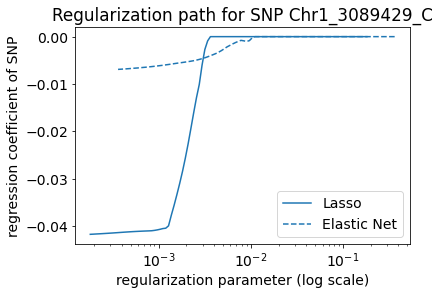

In [23]:
ax = plt.gca()

color = next(ax._get_lines.prop_cycler)['color'] # use the same color for Lasso and Elastic Net
plt.plot(alphas_lasso, coefs_lasso[100, :], label="Lasso", color=color)
plt.plot(alphas_elnet, coefs_elnet[100, :], "--", label="Elastic Net", color=color)

plt.xscale("log")
plt.xlabel("regularization parameter (log scale)")
plt.ylabel("regression coefficient of SNP")
plt.title(f"Regularization path for SNP {genotype_df.columns[100]}")
plt.legend()

__Q: What is the effect of adding l2 regularization on this SNP's coefficient?__

__Answer:__

Let us now compare Lasso and Elastic Net for all SNPs with a rather large coefficient along the way:

In [24]:
non_zero_coef_ = np.where(np.max(np.abs(coefs_lasso), axis=1) > 0.18)[0]

Text(0.5, 1.0, 'Regularization paths for the Lasso and Elastic Net')

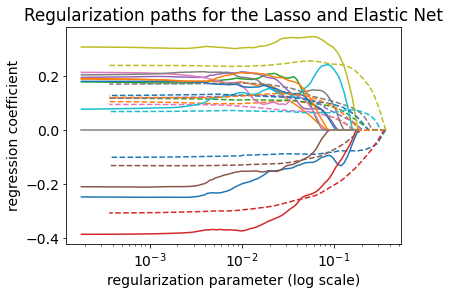

In [25]:
ax = plt.gca()
for feature_idx in non_zero_coef_:
    color = next(ax._get_lines.prop_cycler)['color'] # use the same color for Lasso and Elastic Net
    plt.plot(alphas_lasso, coefs_lasso[feature_idx, :], color=color)
    plt.plot(alphas_elnet, coefs_elnet[feature_idx, :], "--", color=color)
plt.plot(alphas_lasso, [0 for x in alphas_lasso], 'gray') # y=0 axis
plt.xscale("log")
plt.xlabel("regularization parameter (log scale)")
plt.ylabel("regression coefficient")
plt.title("Regularization paths for the Lasso and Elastic Net")

__Q: Do you confirm the effect of adding l2 regularization on the model coefficients?__

__Answer:__

### Fitting an elastic-net

In [26]:
alpha_max, alpha_min = linear_model._coordinate_descent._alpha_grid(X_2W_tr, y_2W_tr_scaled, n_alphas=2, l1_ratio=0.5)
print(f"The maximum value of alpha (for a l1_ratio of 0.5) is {alpha_max:.3f}.")

The maximum value of alpha (for a l1_ratio of 0.5) is 0.363.


In [27]:
elnet = linear_model.ElasticNet(fit_intercept=True, max_iter=1000)

In [28]:
# Grid of values for the two regularization parameters
alphas = linear_model._coordinate_descent._alpha_grid(X_2W_tr, y_2W_tr_scaled, n_alphas=10)
ratios = np.linspace(0.5, 0.9, num=5)

# Set up the grid search cross validation
model_l1l2 = model_selection.GridSearchCV(elnet, param_grid={'alpha': alphas, 'l1_ratio': ratios}, 
                                          cv=3, verbose=1)

# Use the grid search cross validation on the training data
model_l1l2.fit(X_2W_tr, y_2W_tr_scaled)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': array([1.81748112e-01, 8.43600008e-02, 3.91564438e-02, 1.81748112e-02,
       8.43600008e-03, 3.91564438e-03, 1.81748112e-03, 8.43600008e-04,
       3.91564438e-04, 1.81748112e-04]),
                         'l1_ratio': array([0.5, 0.6, 0.7, 0.8, 0.9])},
             verbose=1)

In [29]:
print(f"The best value of alpha is {model_l1l2.best_params_['alpha']:.3f} "
     f"and the best value of l1_ratios is {model_l1l2.best_params_['l1_ratio']:.1f}")

The best value of alpha is 0.182 and the best value of l1_ratios is 0.7


### Selected SNPs

Text(0.5, 1.0, 'Regression coefficients of an elastic net')

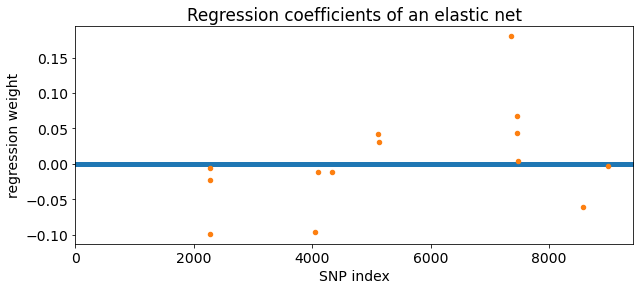

In [30]:
nonzero_weight_indices = np.where(model_l1l2.best_estimator_.coef_)[0]

plt.figure(figsize = (10, 4))
# plot for all SNPs
plt.scatter(range(num_snps), model_l1l2.best_estimator_.coef_, s=10) 
# plot for SNPs with nonzero coefficients
plt.scatter(nonzero_weight_indices, model_l1l2.best_estimator_.coef_[nonzero_weight_indices], s=20) 

plt.xlabel("SNP index")
plt.ylabel("regression weight")
plt.xlim([0, num_snps])
plt.title("Regression coefficients of an elastic net")

__Q: Compare these regression coefficients to that of a lasso. Can you see why we can hope this solution to be more stable?__

__Answer:__

In [31]:
selected_candidate_genes = []
num_snps_pointing_to_candidates = 0
for snp_name in genotype_df.columns[nonzero_weight_indices]:
    matching_genes = genes_by_snp[snp_name]
    candidate_matching_genes = set(matching_genes).intersection(set(candidate_genes))
    if len(candidate_matching_genes):
        num_snps_pointing_to_candidates += 1
        selected_candidate_genes.extend(candidate_matching_genes)
print(f"{num_snps_pointing_to_candidates} of the {len(nonzero_weight_indices)} selected SNP(s) point to {len(selected_candidate_genes)} candidate genes.")

14 of the 14 selected SNP(s) point to 14 candidate genes.


In [32]:
print(selected_candidate_genes)

['AT1G79730', 'AT1G79730', 'AT1G79730', 'AT3G11540', 'AT3G12810', 'AT3G19980', 'AT3G62090', 'AT3G62090', 'AT5G04240', 'AT5G10140', 'AT5G10140', 'AT5G10140', 'AT5G39660', 'AT5G60100']


### Quality of model fit

As before, we can check how well our model fits the data it was trained on.

In [33]:
y_2W_l1l2_pred = model_l1l2.best_estimator_.predict(X_2W_tr)
pve = metrics.explained_variance_score(y_2W_tr_scaled, y_2W_l1l2_pred) * 100
print(f"The percentage of variance explained by an elastic net using all SNPs is {pve:.0f}%")

The percentage of variance explained by an elastic net using all SNPs is 20%


We can also plot the predictions vs the true phenotype for all samples from the train set:

Text(0.5, 1.0, 'Goodness of fit of the elastic net')

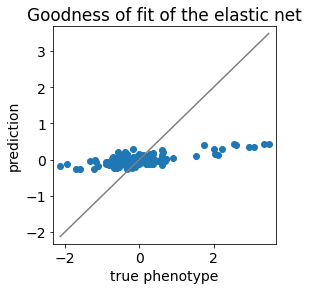

In [34]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_tr_scaled, y_2W_l1l2_pred)

# plot a line y=x
x_min = np.min(y_2W_tr_scaled)
x_max = np.max(y_2W_tr_scaled)
plt.plot([x_min, x_max], [x_min, x_max], c='gray')

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([x_min-0.2, x_max+0.2])
plt.ylim([x_min-0.2, x_max+0.2])

plt.title("Goodness of fit of the elastic net")

__Q: How well does the model fit the training data? Compare to the linear regression and to the lasso. Is this surprising?__

**Answer:**

### Model predictive power 

Again, we can use the test set to evaluate the predictive power of the model, on the test set.

In [ ]:
y_2W_l1l2_pred = model_l1l2.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained by an elastic net (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1l2.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te_scaled, y_2W_l1l2_pred)))

And let us plot the predictions vs the true phenotype for all samples from the test set:

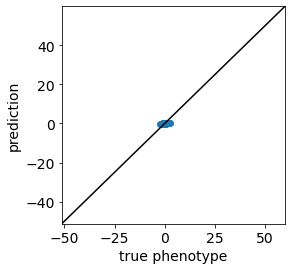

In [82]:
plt.figure(figsize = (4, 4))
plt.scatter(y_2W_te_scaled, y_2W_l1l2_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.ylim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.axline(xy1 = [0, 0], slope = 1, c = "black")

__Q: How well does the model predict on the test data? Compare to previous models__

**Answer:**

## Stability of Elastic Net

Let us wrap what we did in the Lasso section into a method which takes a data set as input and selects the features significantly associated with the output.

In [83]:
def elnet_selection_procedure(X_train, y_train):
    """
    Fits an elastic net on the data. Returns the features with non-zero coefficients.
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected
            selection[j] = 1 otherwise.       
    """
    # create an elatic net object
    elnet = linear_model.ElasticNet(fit_intercept=True, max_iter=1000)
    
    # Grid of values for the regularization hyperparameters
    alphas = linear_model._coordinate_descent._alpha_grid(X_train, y_train, l1_ratio=0.5, n_alphas=10)
    ratios = np.linspace(0.5, 0.9, num=5)

    # Set up the grid search cross validation
    model_l1l2 = model_selection.GridSearchCV(elnet, param_grid={'alpha': alphas, 'l1_ratio': ratios}, 
                                              cv=3)

    # Use the grid search cross validation on the training data
    model_l1l2.fit(X_train, y_train)
    
    print(f"Selected SNPs: {*genotype_df.columns[np.where(model_l1l2.best_estimator_.coef_)[0]],}")    
    
    # Consider the non-zero coefficients as selected
    return(np.where(model_l1l2.best_estimator_.coef_, 1, 0))

In [84]:
# use 90% of the data size as subsample size
subsize = int(round(0.9*len(y_2W_tr)))

# compute stability
elnet_stab = stability(X_2W_tr, y_2W_tr_scaled, elnet_selection_procedure, 10, subsize)

Selected SNPs: ('Chr1_9615772_T', 'Chr1_18325367_A', 'Chr1_22485675_T', 'Chr1_23248789_C', 'Chr1_28960616_T', 'Chr1_29026259_C', 'Chr1_29026627_A', 'Chr1_29041439_C', 'Chr1_29041794_T', 'Chr1_29043091_G', 'Chr1_29044150_C', 'Chr1_29045537_A', 'Chr1_29045883_A', 'Chr1_29900726_A', 'Chr1_30020590_T', 'Chr1_30020796_A', 'Chr1_30021468_T', 'Chr1_30022260_T', 'Chr1_30347069_A', 'Chr2_8438294_A', 'Chr2_8446992_T', 'Chr2_8449271_A', 'Chr2_8449743_C', 'Chr2_8450869_C', 'Chr2_8453619_T', 'Chr2_8454873_C', 'Chr2_8459480_T', 'Chr2_8459532_T', 'Chr2_8459729_T', 'Chr2_8459812_T', 'Chr2_8460494_C', 'Chr2_8460703_G', 'Chr2_8460847_C', 'Chr2_8478404_G', 'Chr2_11041934_A', 'Chr2_18425301_A', 'Chr2_19019256_T', 'Chr3_476716_A', 'Chr3_505329_A', 'Chr3_507969_G', 'Chr3_3652430_A', 'Chr3_4073356_C', 'Chr3_4073911_C', 'Chr3_6983030_C', 'Chr3_22984636_T', 'Chr3_22988447_A', 'Chr3_23008395_C', 'Chr4_280070_A', 'Chr4_287861_G', 'Chr4_454422_C', 'Chr4_454542_A', 'Chr4_475593_A', 'Chr4_1241727_T', 'Chr4_1241765_

In [85]:
print(f"The stability of the ElasticNet selection is: {elnet_stab:.3f}")

The stability of the ElasticNet selection is: 0.373


__Q: Compare this stability to that of the lasso and the t-test. Does it match your expectations?__

**Answer:**

## Stability of Elastic Net with fixed regularization coefficients

As with the Lasso, we can fix the values of the regularization coefficients to see whether this improves stability.

In [86]:
def fixed_hyperparam_elnet_selection_procedure(X_train, y_train):
    """
    Fits an elastic net on the data. Returns the features with non-zero coefficients.

    Rather than cross-validating the values of alpha and l1_ratio, cheat 
    and use the previously determined optimal values.
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected
            selection[j] = 1 otherwise.       
    """
    # create an elastic net object
    model_l1l2 = linear_model.ElasticNet(fit_intercept=True, alpha=0.1, l1_ratio=0.6, max_iter=1000)

    # Use the grid search cross validation on the training data
    model_l1l2.fit(X_train, y_train)
    
    print(f"Selected SNPs: {*genotype_df.columns[np.where(model_l1l2.coef_)[0]],}")    

    # Consider the non-zero coefficients as selected
    return(np.where(model_l1l2.coef_, 1, 0))

In [87]:
# use 90% of the data size as subsample size
subsize = int(round(0.9*len(y_2W_tr)))

# compute stability
elnet_stab = stability(X_2W_tr, y_2W_tr_scaled, fixed_hyperparam_elnet_selection_procedure, 10, subsize)

Selected SNPs: ('Chr1_4275011_T', 'Chr1_4529000_A', 'Chr1_5156423_T', 'Chr1_8993125_G', 'Chr1_9615772_T', 'Chr1_16466187_A', 'Chr1_17843006_A', 'Chr1_18325367_A', 'Chr1_21395824_C', 'Chr1_23267179_A', 'Chr1_24322419_G', 'Chr1_25973043_G', 'Chr1_28960616_T', 'Chr1_28964253_G', 'Chr1_29900726_A', 'Chr1_30020796_A', 'Chr1_30021468_T', 'Chr1_30022260_T', 'Chr2_8195914_C', 'Chr2_8446992_T', 'Chr2_8449743_C', 'Chr2_8478404_G', 'Chr2_9581605_C', 'Chr2_18045473_T', 'Chr2_19019256_T', 'Chr3_476716_A', 'Chr3_505329_A', 'Chr3_507969_G', 'Chr3_1256038_T', 'Chr3_1257380_C', 'Chr3_1423930_G', 'Chr3_3625191_C', 'Chr3_3652430_A', 'Chr3_4047086_T', 'Chr3_4073356_C', 'Chr3_4073911_C', 'Chr3_4079372_G', 'Chr3_6983030_C', 'Chr3_17951762_A', 'Chr3_20236730_T', 'Chr3_20390008_G', 'Chr3_21224440_A', 'Chr3_21245739_C', 'Chr3_22984636_T', 'Chr3_22998693_G', 'Chr3_23003259_A', 'Chr3_23003512_G', 'Chr3_23008395_C', 'Chr4_197103_C', 'Chr4_198176_C', 'Chr4_475593_A', 'Chr4_877075_T', 'Chr4_1261211_A', 'Chr4_864988

In [88]:
print(f"The stability of the Elastic Net selection with fixed regularization hyperparemeters is: {elnet_stab:.3f}")

The stability of the Elastic Net selection with fixed regularization hyperparemeters is: 0.473


__Q: Compare this stability to that of the elastic net with cross-validation of the hyperparameters. Does it match your expectations?__

**Answer:**